<a href="https://www.kaggle.com/code/fiftythirtyfour/airline-delays?scriptVersionId=163496759" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

# Load
ref = pd.read_csv('/kaggle/input/flight-delays/airports.csv')
airlines = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv'
    , dtype={'ORIGIN_AIRPORT': 'object'
             , 'DESTINATION_AIRPORT': 'object'
             , 'SCHEDULED_DEPARTURE': 'object'
             , 'SCHEDULED_ARRIVAL': 'object'
             , 'DEPARTURE_TIME': 'object'
             , 'ARRIVAL_TIME': 'object'
             , 'SCHEDULED_TIME': 'object'
             , 'ELAPSED_TIME': 'object'
             , 'AIR_TIME': 'object'
             , 'WHEELS_OFF': 'object'
             , 'WHEELS_ON': 'object'
             , 'TAXI_IN': 'object'
             , 'TAXI_OUT': 'object'})

# Clean
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['otp_dep15'] = np.where(df['departure_delay'] <= 15, 1, 0)

In [2]:
## Cleaning Time
def convert_time(col):
    return pd.to_datetime(col, format='%H%M', errors='coerce').dt.time

tim = ['scheduled_departure', 'departure_time', 'taxi_out',
       'wheels_off', 'scheduled_time', 'elapsed_time', 'air_time',
       'wheels_on', 'taxi_in', 'scheduled_arrival', 'arrival_time']

for tt in tim:
    df[tt] = convert_time(df[tt])

# Organization
tim.append('date')
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object' and x not in tim]
target = 'otp_dep15'
num.remove(target)

# Explore

## Flights by Airlines
Listed all the flights just to check the integrity of the data and saw some that US airline had only half a year worth of data.

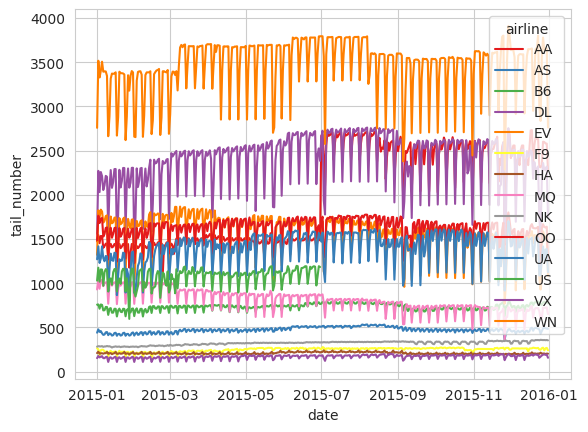

In [3]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## American Airlines and US Airways Merger
It turns out that in 2015, US Airways was acquired by American Airlines.

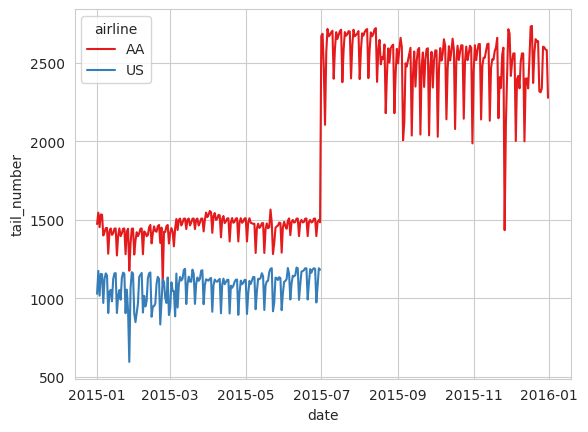

In [4]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["US", "AA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## On Time Performance

On Time Performance is very important for an airline operation. An airline has X amount of flights scheduled in a given period. Each flight is money for the airline. If a flight does not depart on schedule, it will affect the next flight. If enough flights are late, then it increase the chances of cancelling a flight. This does not only mean a loss of potential revenue but also means cost to the airline because it has already paid for most of the stuff to operate that cancelled flight. Therefore, it is important to know how often does a flight depart late, what causes it and how can we prevent it from happening.

Airline industry defines a flight to be on time if it departed within 15 minutes of schedule. Airlines can handle a few delayed flights. It does not matter how long a flight was delayed. A flight that is delayed for 3+hours is manageable. 50 flights that are delayed for 16 minutes is trouble. Airlines can always use a spare aircraft or another aircraft that arrived early to take on the next flight. But they can only do that a finite amount of time because they would want all of their aircrafts to be flying. Therefore, it does not matter how long a flight is delayed, what matters is the frequency.

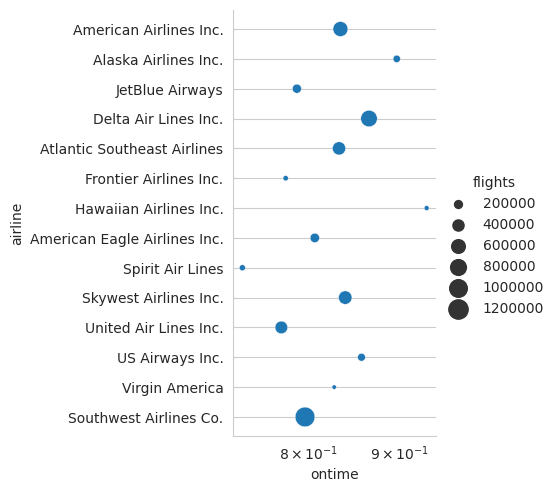

In [5]:
g = df.loc[(df['diverted']==0) & (df['cancelled']==0)]
# g[target].mean()
g = g.groupby('airline')[target].agg(['mean', 'count'])
g = g.reset_index()
g['airline'] = g['airline'].map(airlines.set_index('IATA_CODE')['AIRLINE'])
g.columns = ['airline', 'ontime', 'flights']
sns.relplot(data=g, x='ontime', y='airline', size='flights', sizes=(10, 200))
plt.xscale('log')  # Apply logarithmic scale to the size axis
plt.show()

Here we can see that some Hawaiian Airlines and Alaska Airlines are almost always on time but the volume of flights are low. Delta Airlines are not the best but relative to their size, they have an impressive on-time performance. Spirit Airlines is almost always late and relative to their size, they are really performing bad.

## How often do Cancellations happen?
Around 1-2% of flights for an airline would be cancelled in a given year. Cancellations on the month of February would be more frequent. This could probably due to the weather in North America. American Eagle Airlines had a lot of cancellations relative to their peers. Alaska, Delta and Hawaiian Airlines would rarely cancel their flights.

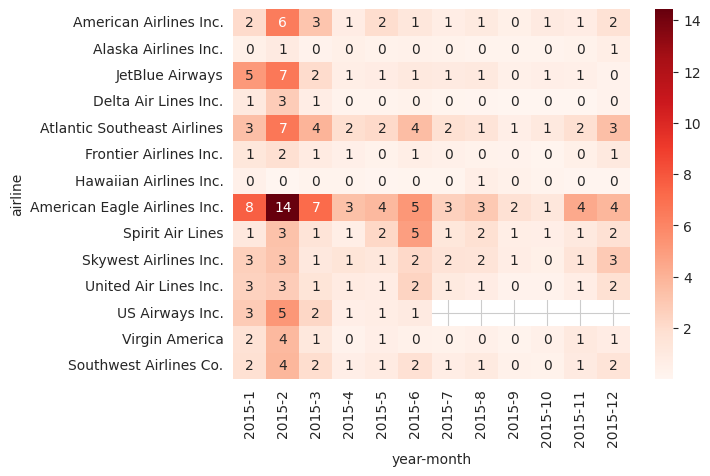

In [6]:
g = df.pivot_table('cancelled', columns=['year', 'month']
              , index=['airline'], aggfunc='mean') * 100
g.index = g.index.map(airlines.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, annot=True, cmap='Reds', fmt=".0f");

## Which Airlines depart On Time?
Between Sep to Nov, airlines are almost always on time with an OTP performance of above 80-85%. Delays are expected around February where almost all airlines have trouble. Hawaiian, Alaskan and Delta are almost always on time regardless of the time of the year, which is most likely due to the weather. American Airlines again is lagging behind in OTP. While around summer time, Spirit, United and Southwest had more delays than the rest. Something is happening their that is affecting their On time Performance.

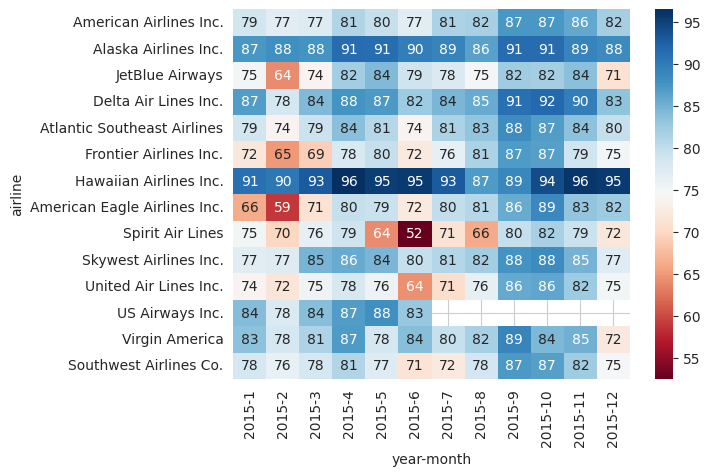

In [7]:
g = df.pivot_table(target, index='airline'
               , columns=['year', 'month'], aggfunc='mean') * 100
g.index = g.index.map(airlines.set_index('IATA_CODE')['AIRLINE']) 
sns.heatmap(g, cmap='RdBu', fmt='.0f', annot=True);

In [8]:
df.cancellation_reason.value_counts()

cancellation_reason
B    48851
A    25262
C    15749
D       22
Name: count, dtype: int64

In [9]:
df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,otp_dep15
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,23:54:00,-11.0,02:01:00,00:15:00,20:05:00,19:04:00,16:09:00,1448,04:04:00,NaT,04:30:00,04:08:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,1
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,00:10:00,00:02:00,-8.0,01:02:00,00:14:00,NaT,NaT,NaT,2330,07:37:00,NaT,07:50:00,07:41:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,1
2,2015,1,1,4,US,840,N171US,SFO,CLT,00:20:00,00:18:00,-2.0,01:06:00,00:34:00,NaT,NaT,NaT,2296,08:00:00,01:01:00,08:06:00,08:11:00,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,1
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,00:20:00,00:15:00,-5.0,01:05:00,00:30:00,NaT,NaT,02:58:00,2342,07:48:00,NaT,08:05:00,07:56:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,1
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,00:25:00,00:24:00,-1.0,01:01:00,00:35:00,23:05:00,21:05:00,19:09:00,1448,02:54:00,NaT,03:20:00,02:59:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,1


In [10]:
df.pivot_table('late_aircraft_delay', index='airline'
              , columns=['year', 'month'], aggfunc='mean')

year          2015                                                         \
month           1          2          3          4          5          6    
airline                                                                     
AA       23.701543  20.115962  22.572965  24.837074  24.410120  27.520547   
AS       20.869520  22.557506  20.032995  16.536603  13.854935  18.298946   
B6       21.933050  26.327104  26.731628  22.696086  20.780855  24.808957   
DL       14.708771  19.154324  16.787463  16.514698  20.651123  20.883640   
EV       23.117096  22.980744  24.066937  21.135899  26.727693  27.036868   
F9       30.972106  32.229991  28.025106  21.733753  23.607109  30.444265   
HA       16.842397  15.039177  12.055128   8.102088  13.346154   8.106969   
MQ       25.981257  26.320928  23.023359  20.479693  21.197001  22.330734   
NK       10.519182  20.966875  21.122777  16.802671  27.692434  32.158859   
OO       30.728842  29.114092  25.313600  25.720427  23.923969  27.507510   
UA       19.911796  18.009893  22.122212  24.365150  25.418846  31.154280   
US       13.475091  15.788409  14.593469  11.796722  14.118531  15.592577   
VX       16.059524  25.433850  22.826498  18.280303  20.225329  20.402218   
WN       24.925421  23.379211  25.604286  24.957511  28.451539  29.279772   

year                                                                       
month           7          8          9          10         11         12  
airline                                                                    
AA       23.144121  20.667705  17.494540  18.899892  19.134643  20.021156  
AS       17.252540  14.830540  12.865986  14.158981  17.101538  16.313320  
B6       24.108063  26.998298  19.140112  17.928020  18.429137  29.027664  
DL       18.807357  18.807257  13.942640  13.045741  14.669903  22.600550  
EV       24.654372  24.657271  19.940614  21.083644  23.322958  26.990844  
F9       24.702739  22.020776  29.668190  19.671441  23.152284  32.829445  
HA       13.836129  24.064542  17.251320  11.418149   9.432203  10.062212  
MQ       23.577007  23.035641  19.987689  22.636364  24.316334  21.656104  
NK       22.435823  19.851687  19.046532   4.417167  13.675845  21.165445  
OO       27.934891  25.090544  22.994673  22.631698  25.068070  28.626241  
UA       30.112888  25.754106  22.677541  24.773626  28.389441  33.465033  
US             NaN        NaN        NaN        NaN        NaN        NaN  
VX       19.716966  22.301025  14.570597  24.310306  17.734545  30.429779  
WN       30.604696  28.464738  22.394500  23.294590  22.363092  28.493366

In [11]:
delays = [x for x in df.columns if 'delay' in x]
delays.remove('departure_delay')
delays.remove('arrival_delay')

In [12]:
df.query("cancelled==0 & diverted==0")[delays].mean()

air_system_delay       13.480568
security_delay          0.076154
airline_delay          18.969547
late_aircraft_delay    23.472838
weather_delay           2.915290
dtype: float64